In [1]:
import random
import numpy as np
import pandas as pd
from skfibers.fibers import FIBERS
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
def censor_test(number_of_instances=5000, number_of_features=50, number_of_features_in_bin=10,
                               no_fail_proportion=0.5, mm_frequency_range=(0.4, 0.5), noise_frequency=0.1,
                               class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                               censoring_frequency=0.5, random_seed=None, negative=False):
    if random_seed:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))

    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns = predictive_features + random_features + ['TrueRiskGroup', 'Duration']

    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list

    # Generating predictive and random features columns
    mm_frequency_seeds = np.random.randint(0, number_of_instances * number_of_instances, size=number_of_instances)
    df = df.apply(generate_features,
                  args=(number_of_features, number_of_features_in_bin,
                        mm_frequency_range, mm_frequency_seeds), axis=1).astype(int)

    # Assigning Gaussian according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0],
                                                class0_time_to_event_range[1], size=len(df_0)),
                               a_min=0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0],
                                                class1_time_to_event_range[1], size=len(df_1)),
                               a_min=0, a_max=None)
    
    df = pd.concat([df_0, df_1])
    return df

In [3]:
def generate_features(row, number_of_features, number_of_features_in_bin, mm_frequency_range, random_seeds=None):
    np.random.seed(int(random_seeds[row.name]))
    random.seed(int(random_seeds[row.name]))
    mm_frequency = np.random.uniform(mm_frequency_range[0], mm_frequency_range[1])
    if row['TrueRiskGroup'] == 1:
        indexes = random.sample(list(range(1, number_of_features_in_bin + 1)),
                                int(mm_frequency * number_of_features_in_bin))
        for idx in indexes:
            row['P_' + str(idx)] = 1
        indexes = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)),
                                int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in indexes:
            row['R_' + str(idx)] = 1
    else:
        indexes = random.sample(list(range(1, number_of_features - number_of_features_in_bin + 1)),
                                int(mm_frequency * (number_of_features - number_of_features_in_bin)))
        for idx in indexes:
            row['R_' + str(idx)] = 1
    return row

In [19]:
def censor(df, censoring_frequency, random_seed=None):
    df['Censoring'] = 1
    inst_to_censor = int(censoring_frequency * len(df))
    max_duration = max(df['Duration'])
    df = df.sort_values('Duration')
    censor_count = 0
    count = 0
    print(inst_to_censor)
    while censor_count < inst_to_censor:
        if random_seed:
            np.random.seed(random_seed + count)
        for index in range(len(df)):
            prob = df['Duration'].iloc[index] / max_duration
            choice = np.random.choice([0, 1], 1, p=[prob, 1 - prob])
            if censor_count >= inst_to_censor:
                break
            if choice == 0:
                censor_count += 1
            df['Censoring'].iloc[index] = choice
            count += 1
    print(len(df[df['Censoring']==0]))
    return df

In [20]:
def create_data_simulation_bin(number_of_instances=5000, number_of_features=50, number_of_features_in_bin=10,
                               no_fail_proportion=0.5, mm_frequency_range=(0.4, 0.5), noise_frequency=0.1,
                               class0_time_to_event_range=(1.5, 0.2), class1_time_to_event_range=(1, 0.2),
                               censoring_frequency=0.5, random_seed=None, negative=False):
    """
    Defining a function to create an artificial dataset with parameters, there will be one ideal/strong bin
    Note: MAF (minor allele frequency) cutoff refers to the threshold
    separating rare variant features from common features

    :param number_of_instances: dataset size
    :param number_of_features: total number of features in dataset
    :param number_of_features_in_bin: total number of predictive features in the ideal bin
    :param no_fail_proportion: the proportion of instances to be labeled as (no fail class)
    :param mm_frequency_range: the max and min MM frequency for a given column/feature in data. (e.g. 0.1 to 0.5)
    :param noise_frequency: Value from 0 to 0.5 representing the proportion of class 0/class 1 instance pairs that \
                            have their outcome switched from 0 to 1
    :param class0_time_to_event_range: (min, max) time to event as a tuple (should be larger (e.g. 100 to 200)
    :param class1_time_to_event_range: (min, max) time to event as a tuple (should be smaller but a bit overlapping \
                                        with above range (e.g. 20 to 150)
    :param censoring_frequency:
    :param random_seed:
    :param negative:

    :return: pandas dataframe of generated data
    """
    if random_seed:
        random.seed(random_seed)
        np.random.seed(random_seed)

    # Creating an empty dataframe to use as a starting point for the eventual feature matrix
    # Adding one to number of features to give space for the class and Duration column
    df = pd.DataFrame(np.zeros((number_of_instances, number_of_features + 2)))

    # Creating a list of predictive features in the strong bin
    predictive_features = ["P_" + str(i + 1) for i in range(number_of_features_in_bin)]

    # Creating a list of randomly created features
    random_features = ["R_" + str(i + 1) for i in range(number_of_features - number_of_features_in_bin)]

    # Adding the features and the class/endpoint
    df.columns = predictive_features + random_features + ['TrueRiskGroup', 'Duration']

    # Assigning class according to no_fail_proportion parameter
    fail_count = int(number_of_instances * (1 - no_fail_proportion))
    no_fail_count = number_of_instances - fail_count
    class_list = [1] * fail_count + [0] * no_fail_count
    df['TrueRiskGroup'] = class_list

    # Generating predictive and random features columns
    mm_frequency_seeds = np.random.randint(0, number_of_instances * number_of_instances, size=number_of_instances)
    df = df.apply(generate_features,
                  args=(number_of_features, number_of_features_in_bin,
                        mm_frequency_range, mm_frequency_seeds), axis=1).astype(int)

    # Assigning Gaussian according to class
    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    df_0['Duration'] = np.clip(np.random.normal(class0_time_to_event_range[0],
                                                class0_time_to_event_range[1], size=len(df_0)),
                               a_min=0, a_max=None)
    df_1['Duration'] = np.clip(np.random.normal(class1_time_to_event_range[0],
                                                class1_time_to_event_range[1], size=len(df_1)),
                               a_min=0, a_max=None)
    df = censor(pd.concat([df_0, df_1]), censoring_frequency, random_seed)

    df_0 = df[df['TrueRiskGroup'] == 0].sample(frac=1).reset_index(drop=True)
    df_1 = df[df['TrueRiskGroup'] == 1].sample(frac=1).reset_index(drop=True)
    if noise_frequency > 0:
        swap_count = int(min(len(df_0), len(df_1)) * noise_frequency)
        indexes = random.sample(list(range(min(len(df_0), len(df_1)))), swap_count)
        for i in indexes:
            df_0['Censoring'].iloc[i], df_1['Censoring'].iloc[i] = \
                df_1['Censoring'].iloc[i].copy(), df_0['Censoring'].iloc[i].copy()
            df_0['Duration'].iloc[i], df_1['Duration'].iloc[i] = \
                df_1['Duration'].iloc[i].copy(), df_0['Duration'].iloc[i].copy()

    df = pd.concat([df_0, df_1]).sample(frac=1).reset_index(drop=True)

    if negative:
        df['Censoring'] = list(df['Censoring'].sample(frac=1))
        df['Duration'] = list(df['Duration'].sample(frac=1))

    return df

In [24]:
data = create_data_simulation_bin(censoring_frequency=0.5)
data = data.drop('TrueRiskGroup', axis=1)
fibers = FIBERS(label_name="Censoring", duration_name="Duration", 
                        given_starting_point=False, amino_acid_start_point=None,
                        amino_acid_bins_start_point=None, iterations=100, 
                        set_number_of_bins=50, min_features_per_group=2,
                        max_number_of_groups_with_feature=2, 
                        informative_cutoff=0.2, crossover_probability=0.8,
                        mutation_probability=0.4, elitism_parameter=0.8,
                        random_seed=42)
fibers.fit(data)

2500
2500


100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


FIBERS(crossover_probability=0.8, iterations=100, label_name='Censoring',
       max_number_of_groups_with_feature=2, random_seed=42)

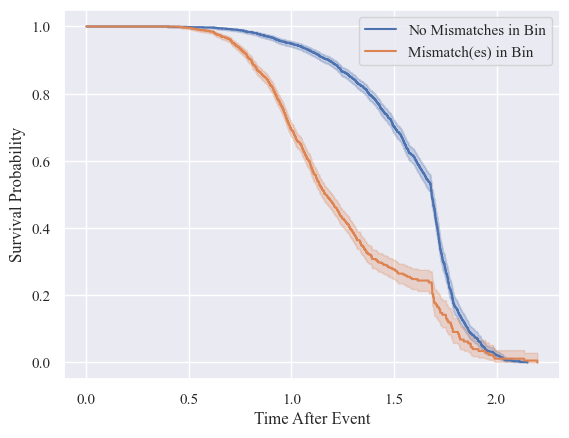

In [25]:
fibers.get_bin_survival_plot(show=True)

In [26]:
fibers.get_bin_scores()

,Bin #,Score,Bins
0,Bin 16,890.285401,"[P_6, P_3, P_10, P_5]"
1,Bin 34,832.771414,"[P_9, P_5, P_3]"
2,Bin 33,798.330197,"[P_4, P_5, P_7]"
3,Bin 6,791.287370,"[P_4, P_9, P_3]"
4,Bin 4,781.255848,"[P_1, P_9, P_10]"
5,Bin 8,781.255848,"[P_9, P_10, P_1]"
6,Bin 31,780.137844,"[P_5, P_6, P_3]"
7,Bin 35,776.421600,"[P_8, P_5, P_9]"
8,Bin 13,755.606171,"[P_5, P_9, P_2]"
9,Bin 40,746.687584,"[P_5, P_6, P_2]"
